In [2]:
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [3]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from fractions import Fraction
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter
from torch.utils.data import Sampler


In [4]:
# ------------- Config -------------
DELTA_MIN = 0.0
DELTA_MAX = math.pi/3  # restrict phase to [0, π/3]
SEED          = 42
SIDE          = 96
TRAIN_SAMPLES = 12000
VAL_SAMPLES   = 2000
EPOCHS        = 15
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 1e-5
RATIOS        = [(1,3)]      # 필요시 다중 비율 가능 e.g. [(1,2),(1,3),(2,3)]

# Augment
THICKNESS_PX  = (1, 3)
GRID_PROB     = 0.35
NOISE_STD     = (0, 10)
ROT_JIT_DEG   = (-6, 6)
SCALE_JIT     = (0.94, 1.06)


In [5]:
# ---------------- Utils (revised) ----------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

def delta_to_pi_fraction(delta_rad, max_den=180):
    r = float(delta_rad % (2*np.pi)) / np.pi
    frac = Fraction(r).limit_denominator(max_den)
    k, n = frac.numerator, frac.denominator
    return ("0" if k==0 else (f"{k}π" if n==1 else f"{k}π/{n}"))

def lissajous_points(a,b,delta,n=1500,tmax=2*np.pi):
    t = np.linspace(0, tmax, n)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    return x, y

def draw_curve(size, a, b, delta, thickness=2, margin=0.06):
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    x, y = lissajous_points(a,b,delta)
    x = x/(np.max(np.abs(x))+1e-9)
    y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

def apply_random_pose(img):
    ang = random.uniform(*ROT_JIT_DEG)
    sx  = random.uniform(*SCALE_JIT)
    sy  = random.uniform(*SCALE_JIT)
    nx, ny = int(img.width*sx), int(img.height*sy)
    img2 = img.resize((nx, ny), resample=Image.BILINEAR)
    canvas = Image.new('L', img.size, 255)
    ox, oy = (canvas.width-img2.width)//2, (canvas.height-img2.height)//2
    canvas.paste(img2, (ox, oy))
    return canvas.rotate(ang, resample=Image.BILINEAR, fillcolor=255)

def overlay_grid(img):
    if random.random() > GRID_PROB: return img
    g = Image.new('L', img.size, 255); dr = ImageDraw.Draw(g)
    W, H = img.size; step = max(8, W//6); gray = 170
    for x in range(0, W, step): dr.line([(x,0),(x,H)], fill=gray, width=1)
    for y in range(0, H, step): dr.line([(0,y),(W,y)], fill=gray, width=1)
    return Image.blend(img, g, alpha=0.35)

def add_noise(img):
    arr = np.array(img).astype(np.float32)
    std = random.uniform(*NOISE_STD)
    if std>0: arr += np.random.normal(0, std, arr.shape)
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def preprocess_to_tensor(img):
    arr = np.array(img, dtype=np.float32)/255.0
    return torch.from_numpy(arr).unsqueeze(0)   # (1,H,W)


In [6]:
# ========================= Dataset (small-delta aware) =========================
class LissajousPhaseDataset(Dataset):
    """
    합성 이미지 + (a,b) 조건 → label y=(cosδ, sinδ)
    δ는 전구간 균일 + 소/대 위상 근처를 강조하는 혼합 분포로 샘플.
    """
    def __init__(self, size=96, samples=10000, ratios=[(1,3)]):
        self.size = size
        self.samples = samples
        self.ratios  = ratios

    def __len__(self): return self.samples

    def _sample_delta(self):
        # Sample uniformly inside [DELTA_MIN, DELTA_MAX]
        return random.uniform(DELTA_MIN, DELTA_MAX)

    def __getitem__(self, idx):
        a,b = random.choice(self.ratios)
        delta = self._sample_delta()

        img = draw_curve(self.size, a, b, delta,
                         thickness=random.randint(*THICKNESS_PX))
        img = apply_random_pose(img)
        img = overlay_grid(img)
        img = add_noise(img)

        x = preprocess_to_tensor(img)                        # (1,H,W)
        cond = torch.tensor([a/6.0, b/6.0], dtype=torch.float32)
        y = torch.tensor([math.cos(delta), math.sin(delta)], dtype=torch.float32)
        return x, cond, y


In [7]:
# ---------------- Losses ----------------
def angular_loss(pred, target):
    # pred/target: (B,2) 단위벡터
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def circular_uniformity_loss(pred):
    # 배치 평균 벡터 크기 ↓
    m = pred.mean(dim=0)
    return (m*m).sum()

def soft_circ_hist_kl(pred, K=36, kappa=16.0):
    # 배치 δ를 소프트 히스토그램으로 누적 → 균일분포와 KL
    theta = torch.atan2(pred[:,1], pred[:,0]) % (2*np.pi)  # (B,)
    centers = torch.linspace(0, 2*np.pi, K, device=pred.device, dtype=pred.dtype, endpoint=False)
    w = torch.exp(kappa * (torch.cos(theta[:,None] - centers[None,:]) - 1.0))  # (B,K)
    p = (w / (w.sum(dim=1, keepdim=True) + 1e-8)).mean(dim=0)                  # (K,)
    p = (p + 1e-8) / (p.sum() + 1e-8)
    u = torch.full_like(p, 1.0/K)
    return F.kl_div((p+1e-8).log(), u, reduction='batchmean')


In [8]:
# ---------------- Model ----------------
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.c = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=c_out),
            nn.SiLU(inplace=True)
        )
    def forward(self, x): return self.c(x)

class PhaseNet(nn.Module):
    def __init__(self, side=96):
        super().__init__()
        C = 32
        self.backbone = nn.Sequential(
            ConvBNAct(1,   C),   ConvBNAct(C,   C),   nn.AvgPool2d(2),
            ConvBNAct(C, 2*C),   ConvBNAct(2*C,2*C), nn.AvgPool2d(2),
            ConvBNAct(2*C,4*C),  ConvBNAct(4*C,4*C), nn.AvgPool2d(2),
            ConvBNAct(4*C,4*C)
        )
        # (approx) side // 8
        fmap = (side//8)*(side//8)*4*C
        self.cond = nn.Sequential(nn.Linear(2, 32), nn.SiLU(),
                                  nn.Linear(32, 32), nn.SiLU())
        self.head = nn.Sequential(
            nn.Linear(fmap+32, 256), nn.SiLU(),
            nn.Linear(256, 2)
        )
    def forward(self, x, cond):
        f = self.backbone(x).flatten(1)
        c = self.cond(cond)
        y = self.head(torch.cat([f,c],1))
        return F.normalize(y, dim=1)   # 항상 단위 벡터로

In [9]:
# ---------------- Uniform Phase Batch Sampler ----------------
def angular_loss(pred, target):
    # pred/target: (B,2) 단위벡터
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def circular_uniformity_loss(pred):
    # 배치 평균 벡터 크기 ↓
    m = pred.mean(dim=0)
    return (m*m).sum()

def soft_circ_hist_kl(pred: torch.Tensor, K: int = 36, kappa: float = 16.0) -> torch.Tensor:
    """
    pred: (B,2) on the unit circle
    K:    number of circular bins
    kappa: von Mises sharpness (larger = narrower)
    """
    # 각도 추출 [0, 2π)
    theta = torch.atan2(pred[:, 1], pred[:, 0]) % (2 * math.pi)   # (B,)

    # ★ linspace(endpoint=False) 대신 arange로 [0, 2π) 등분
    centers = torch.arange(K, device=pred.device, dtype=pred.dtype) * (2 * math.pi / K)  # (K,)

    # von Mises 기반 소프트 할당 -> 배치 평균 분포 p
    # exp(κ(cos(θ-μ)-1)) 형태라 p의 각 항이 양수이며 [0,1]로 정규화 용이
    w = torch.exp(kappa * (torch.cos(theta[:, None] - centers[None, :]) - 1.0))  # (B,K)
    p = (w / (w.sum(dim=1, keepdim=True) + 1e-8)).mean(dim=0)                    # (K,)

    # 균일분포 q = 1/K 와의 KL(p‖q)
    # KL(p‖q) = Σ p_i (log p_i - log q_i) = Σ p_i log p_i + log K
    p_safe = p.clamp_min(1e-8)
    kl = (p_safe * p_safe.log()).sum() + math.log(K)
    return kl

In [10]:
# ---------------- Uniform Phase Batch Sampler ----------------
class PerBatchUniformSampler(Sampler):
    """각 배치를 K_bin 에서 고르게 뽑아 구성. 배치마다 δ가 원 전역을 커버."""
    def __init__(self, dataset, batch_size, K_bin=36, seed=42, getter=lambda ds,i: ds[i][2]):
        self.ds   = dataset
        self.bs   = batch_size
        self.K    = K_bin
        self.rng  = random.Random(seed)
        # δ 수집
        deltas = []
        for i in range(len(dataset)):
            # getter(ds, i) -> y=(cos,sin)
            y = getter(dataset, i)
            theta = float(np.arctan2(y[1], y[0]) % (2*np.pi))
            deltas.append(theta)
        deltas = np.array(deltas)
        edges  = np.linspace(DELTA_MIN, DELTA_MAX, self.K+1, endpoint=True)
        self.bins = [ [] for _ in range(self.K) ]
        for idx, th in enumerate(deltas):
            k = int(np.searchsorted(edges, th, side='right')-1)
            if k==self.K: k = self.K-1
            self.bins[k].append(idx)
        # 빈 bin 방지: 비어있으면 인접 bin에서 빌려오기
        for k in range(self.K):
            if not self.bins[k]:
                self.bins[k] = list(self.bins[(k-1)%self.K])

    def __iter__(self):
        # 에폭마다 셔플
        ptr = [0]*self.K
        for k in range(self.K):
            self.rng.shuffle(self.bins[k])

        order = []
        N     = len(self.ds)
        # 배치 개수
        n_batches = math.ceil(N / self.bs)
        # 배치마다 고르게 bin를 순회(시작 offset 랜덤)
        start = self.rng.randrange(self.K)
        k = start
        for _ in range(n_batches):
            batch = []
            # 배치가 꽉 찰 때까지 bin를 돌아가며 한 개씩 픽
            while len(batch) < self.bs:
                # 해당 bin 고갈 시 다음 bin
                tries = 0
                while tries < self.K and ptr[k] >= len(self.bins[k]):
                    k = (k+1) % self.K
                    tries += 1
                if tries == self.K:  # 전체 고갈
                    break
                batch.append(self.bins[k][ptr[k]])
                ptr[k] += 1
                k = (k+1) % self.K
            if not batch: break
            order.extend(batch)
        return iter(order)

    def __len__(self):
        return len(self.ds)

In [11]:
# ---------------- Train setup ----------------
set_seed()
full = LissajousPhaseDataset(size=SIDE, samples=TRAIN_SAMPLES+VAL_SAMPLES, ratios=RATIOS)
train_set, val_set = random_split(full, [TRAIN_SAMPLES, VAL_SAMPLES],
                                  generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=False,
    sampler=PerBatchUniformSampler(train_set, BATCH_SIZE, K_bin=36, seed=SEED),
    num_workers=0, pin_memory=False
)

val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = PhaseNet(side=SIDE).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS*len(train_loader))

# 손실 가중치 + 램프업
L_ANG, L_MSE, L_UNIT = 1.0, 0.25, 0.02
L_CUNI, L_HIST       = 0.10, 0.05

def rampup(ep, T=5): return min(1.0, ep/float(T))

best_val = 1e9
ckpt_path = "phase_cnn_best.pt"
print("Device:", device)

for ep in range(1, EPOCHS+1):
    model.train(); tr_loss=0; n=0
    w = rampup(ep)

    for x,cond,y in train_loader:
        x,cond,y = x.to(device), cond.to(device), y.to(device)
        out  = model(x,cond)                 # 이미 normalize 되어 반환
        loss = (L_ANG  * angular_loss(out,y) +
                L_MSE  * F.mse_loss(out,y) +
                L_UNIT * unit_circle_reg(out) +
                (w*L_CUNI) * circular_uniformity_loss(out) +
                (w*L_HIST) * soft_circ_hist_kl(out, K=36, kappa=16.0))

        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sched.step()
        tr_loss += loss.item()*x.size(0); n += x.size(0)
    tr = tr_loss/n

    # ---- validation: 정규화 항 제외 (각도/보조만) ----
    model.eval(); tot=0; n=0; pv=[]
    with torch.no_grad():
        for x,cond,y in val_loader:
            x,cond,y = x.to(device), cond.to(device), y.to(device)
            out = model(x,cond)
            vloss = L_ANG*angular_loss(out,y) + L_MSE*F.mse_loss(out,y)
            tot += vloss.item()*x.size(0); n += x.size(0)
            pv.append(out.var(dim=0, unbiased=False).mean().item())
    va = tot/n; pred_var = float(np.mean(pv))
    print(f"[{ep:02d}] train={tr:.4f} | val={va:.4f} | pred_var≈{pred_var:.4e}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), ckpt_path)
        print("  ✅ Saved best:", ckpt_path)

print("Done. Best ckpt:", ckpt_path)

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_24092\2791678061.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta = float(np.arctan2(y[1], y[0]) % (2*np.pi))


Device: cuda
[01] train=0.1175 | val=0.0013 | pred_var≈5.4476e-02
  ✅ Saved best: phase_cnn_best.pt
[02] train=0.0627 | val=0.0010 | pred_var≈5.3626e-02
  ✅ Saved best: phase_cnn_best.pt
[03] train=0.0927 | val=0.0033 | pred_var≈6.4745e-02
[04] train=0.1219 | val=0.0076 | pred_var≈7.4974e-02
[05] train=0.1509 | val=0.0079 | pred_var≈7.7627e-02
[06] train=0.1503 | val=0.0103 | pred_var≈8.6182e-02
[07] train=0.1508 | val=0.0096 | pred_var≈7.9822e-02
[08] train=0.1505 | val=0.0084 | pred_var≈7.7190e-02
[09] train=0.1504 | val=0.0112 | pred_var≈8.7409e-02
[10] train=0.1504 | val=0.0092 | pred_var≈8.2311e-02
[11] train=0.1503 | val=0.0091 | pred_var≈8.2356e-02
[12] train=0.1505 | val=0.0098 | pred_var≈8.3747e-02
[13] train=0.1504 | val=0.0101 | pred_var≈8.4617e-02
[14] train=0.1502 | val=0.0091 | pred_var≈8.1485e-02
[15] train=0.1507 | val=0.0096 | pred_var≈8.3760e-02
Done. Best ckpt: phase_cnn_best.pt


C:\Users\KOSJ\AppData\Local\Temp\ipykernel_24092\1928601995.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

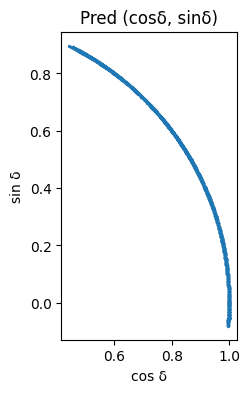

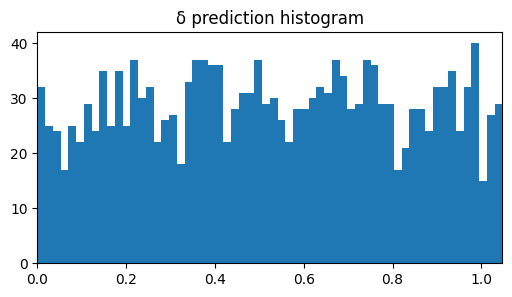

In [12]:
# ---------------- Quick diagnostics (scatter + hist) ----------------
def scatter_hist_on_loader(model, loader, title_prefix="Pred"):
    model.eval(); outs=[]
    with torch.no_grad():
        for x,c,_ in loader:
            o = model(x.to(device), c.to(device)).cpu().numpy()
            outs.append(o)
    outs = np.concatenate(outs,0)
    plt.figure(figsize=(4,4))
    plt.scatter(outs[:,0], outs[:,1], s=2)
    plt.gca().set_aspect('equal'); plt.title(f"{title_prefix} (cosδ, sinδ)")
    plt.xlabel("cos δ"); plt.ylabel("sin δ"); plt.show()

    delta = np.arctan2(outs[:,1], outs[:,0]) % (2*np.pi)
    plt.figure(figsize=(6,3)); plt.hist(delta, bins=60, range=(DELTA_MIN, DELTA_MAX))
    plt.xlim(DELTA_MIN, DELTA_MAX)
    plt.title("δ prediction histogram"); plt.show()

# ===== 사후 점검 =====
model.load_state_dict(torch.load(ckpt_path, map_location=device))
scatter_hist_on_loader(model, val_loader, title_prefix="Pred")

ratio 1:3 | GT δ=42.50° (17π/72)
pred δ=44.13° (38π/155) | err=1.63°


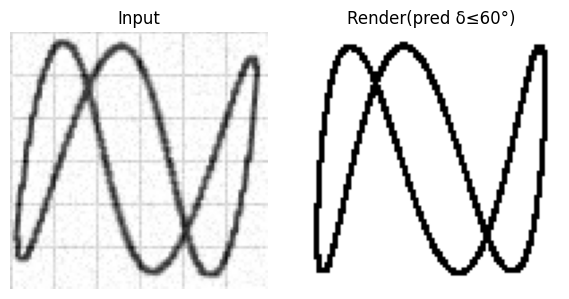

In [16]:
# ---------------- Tiny sanity inference ----------------
def canonical_delta_rad(delta_rad, a, b, clamp_pi_over_3=True):
    """δ(rad)를 리사주 주기 및 좌우반전까지 접어 [0, π·a/b]로 만들고,
       필요시 [0, π/3]로 최종 제한."""
    period = 2*math.pi * a / b          # 2π·a/b
    d = float(delta_rad % period)        # t-shift invariance
    d = min(d, period - d)               # mirror invariance
    if clamp_pi_over_3:
        d = min(d, math.pi/3)            # 최종 [0, π/3]
    return d

def predict_delta(model, pil_gray, a, b, side=SIDE):
    img = pil_gray.convert('L').resize((side, side), Image.BILINEAR)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0, b/6.0]], dtype=torch.float32, device=device)
    with torch.no_grad():
        vec = model(x, cond).cpu().numpy().reshape(2)
    delta = float(np.arctan2(vec[1], vec[0]) % (2*np.pi))
    return delta, img

# 예: 합성 하나를 뽑아 확인 (GT도 canonical + ≤ π/3로)
a, b = random.choice(RATIOS)
gt_delta_raw = random.uniform(0, 2*np.pi)
gt_delta = canonical_delta_rad(gt_delta_raw, a, b, clamp_pi_over_3=True)

img = draw_curve(SIDE, a, b, gt_delta, thickness=2)
img = apply_random_pose(img); img = overlay_grid(img); img = add_noise(img)

pred_raw, viz = predict_delta(model, img, a, b)
pred = canonical_delta_rad(pred_raw, a, b, clamp_pi_over_3=True)

def deg(x): return float(np.degrees(x))
def pi_frac(rad): return delta_to_pi_fraction(rad, max_den=180)

print(f"ratio {a}:{b} | GT δ={deg(gt_delta):.2f}° ({pi_frac(gt_delta)})")
print(f"pred δ={deg(pred):.2f}° ({pi_frac(pred)}) | err={abs(deg(pred)-deg(gt_delta)):.2f}°")

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(viz, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(draw_curve(SIDE, a, b, pred, thickness=2), cmap='gray')
plt.title(f"Render(pred δ≤60°)"); plt.axis('off')
plt.tight_layout(); plt.show()

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_24092\70703018.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device

✅ Loaded checkpoint: phase_cnn_best.pt
→ ratio = 1:3

===== Result =====
Image     : lsj 1 on 3.PNG
δ_pred    : 7.57°  (canonical, ≤60°)
δ_exp     : 0.00°  (canonical, ≤60°)
abs error : 7.57°


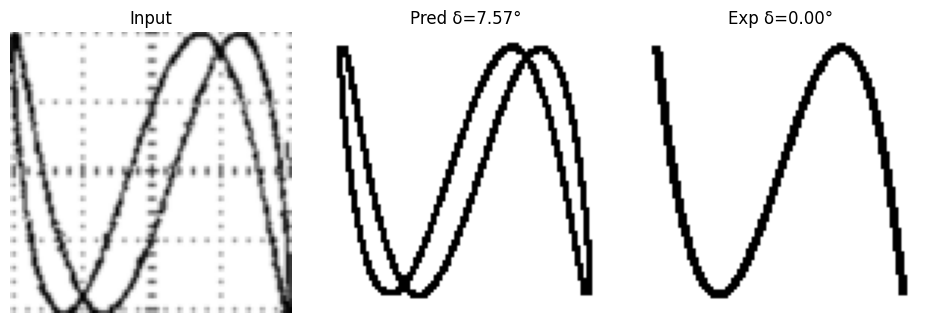

📝 Logged to: C:\Users\KOSJ\Downloads\고가연\inference_log.csv


In [19]:
import os, io, csv, math, json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
from datetime import datetime

# ================= Inference on YOUR experiment image =================
if 'model' in globals() and 'device' in globals():
    if 'ckpt_path' in globals() and os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"✅ Loaded checkpoint: {ckpt_path}")
    else:
        print("ℹ️ ckpt_path가 없거나 파일이 없습니다. 현재 모델 가중치로 진행합니다.")
else:
    raise RuntimeError("model/device가 정의되어 있어야 합니다. 위 학습 셀들을 먼저 실행하세요.")

# ---- Lissajous 보조 함수들 ----
def canonical_delta_rad(delta_rad, a, b, clamp_pi_over_3=True):
    """δ(rad)를 리사주 주기(2π·a/b) 및 좌우반전까지 접어 [0, π·a/b]로 만들고,
       필요시 최종적으로 [0, π/3]로 제한."""
    period = 2*math.pi * a / b
    d = float(delta_rad % period)
    d = min(d, period - d)
    if clamp_pi_over_3:
        d = min(d, math.pi/3)
    return d

def delta_to_deg(rad): return float(np.degrees(rad))
def deg_to_rad(deg):  return float(np.radians(deg))

def draw_curve_quick(size, a, b, delta, thickness=2, margin=0.06):
    t = np.linspace(0, 2*np.pi, 1500)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    x = x/(np.max(np.abs(x))+1e-9); y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    img = Image.new('L', (size, size), 255)
    ImageDraw.Draw(img).line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

def predict_delta(model, pil_gray, a, b, side=SIDE):
    """현재 모델로 δ(rad) 예측 + 전처리된 입력 이미지 반환"""
    img = pil_gray.convert('L').resize((side, side), Image.BILINEAR)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0, b/6.0]], dtype=torch.float32, device=device)
    with torch.no_grad():
        vec = model(x, cond).cpu().numpy().reshape(2)
    delta = float(np.arctan2(vec[1], vec[0]) % (2*np.pi))
    return delta, img

# ---- VSCode/노트북에서 이미지 선택(위젯 있으면 업로드, 없으면 경로/자동탐색) ----
def pick_image_vscode():
    # 1) ipywidgets 업로드 시도
    try:
        import ipywidgets as widgets
        from IPython.display import display, clear_output

        uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg,.bmp', multiple=False)
        btn_done = widgets.Button(description='Use this file', button_style='success')
        out = widgets.Output()

        selected = {'pil': None, 'name': None}

        def on_upload_change(change):
            for _, f in uploader.value.items():
                selected['name'] = f['metadata'].get('name', 'uploaded.png')
                selected['pil']  = Image.open(io.BytesIO(f['content']))
                with out:
                    clear_output(wait=True)
                    print(f"✅ Uploaded: {selected['name']}")
                    display(selected['pil'])

        def on_done_clicked(b):
            if selected['pil'] is None:
                with out:
                    print("⚠️ 먼저 이미지를 업로드하세요.")
            else:
                with out:
                    print("✅ Using uploaded image.")

        uploader.observe(on_upload_change, names='value')
        btn_done.on_click(on_done_clicked)

        display(widgets.VBox([widgets.HTML("<b>이미지 업로드</b>"), uploader, btn_done, out]))

        # 대화형 대기 없이도 사용할 수 있게, 업로드가 없으면 아래 fallback으로 진행
        print("ℹ️ 위젯이 보이지 않거나 업로드하지 않으면 경로 입력/자동탐색으로 넘어갑니다.")
    except Exception:
        pass

    # 2) 경로 직접 입력
    try:
        path_in = input("이미지 경로를 입력(엔터=자동탐색): ").strip()
    except Exception:
        path_in = ""

    if path_in:
        p = Path(path_in).expanduser()
        if not p.exists():
            raise FileNotFoundError(f"Not found: {p}")
        return Image.open(p), p.name

    # 3) 현재 폴더 자동 탐색
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    cwd = Path(".").resolve()
    cands = []
    for e in exts:
        cands += list(cwd.glob(e))
    if not cands:
        raise FileNotFoundError(f"현재 폴더({cwd})에 이미지 파일이 없습니다. 경로를 직접 입력하세요.")
    # 첫 번째 자동 선택 (목록 보여주기)
    print("🔎 Found images:")
    for i, p in enumerate(cands, 1):
        print(f"  [{i}] {p.name}")
    print(f"➡️ 자동 선택: {cands[0].name}")
    return Image.open(cands[0]), cands[0].name

# ---- 실행: ratio/이미지/실험값 입력 → 예측/비교/시각화/로깅 ----
def parse_ratio(s):
    s = s.strip()
    if ":" in s: a,b = s.split(":")
    else:        a,b = s.split()
    return int(a), int(b)

ratio_str = input("각진동수 비를 입력하세요 (예: 1:3) : ").strip() or "1:3"
a, b = parse_ratio(ratio_str)
print(f"→ ratio = {a}:{b}")

pil_in, img_name = pick_image_vscode()

# 예측
pred_raw, viz = predict_delta(model, pil_in, a, b)
pred_canon = canonical_delta_rad(pred_raw, a, b, clamp_pi_over_3=True)
pred_deg   = delta_to_deg(pred_canon)

# 실험값(옵션)
gt_str = input("실험 δ(도, 비우면 스킵): ").strip()
gt_deg = float(gt_str) if gt_str else np.nan
gt_canon = canonical_delta_rad(deg_to_rad(gt_deg), a, b, clamp_pi_over_3=True) if gt_str else np.nan
gt_canon_deg = delta_to_deg(gt_canon) if gt_str else np.nan

# 에러
err_deg = abs(pred_deg - gt_canon_deg) if gt_str else np.nan

# 출력
print("\n===== Result =====")
print(f"Image     : {img_name}")
print(f"δ_pred    : {pred_deg:.2f}°  (canonical, ≤60°)")
if gt_str:
    print(f"δ_exp     : {gt_canon_deg:.2f}°  (canonical, ≤60°)")
    print(f"abs error : {err_deg:.2f}°")

# 시각화 (Input / Pred / Exp(optional))
ncols = 3 if gt_str else 2
plt.figure(figsize=(3.2*ncols, 3.2))
plt.subplot(1,ncols,1); plt.imshow(viz, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,ncols,2); plt.imshow(draw_curve_quick(SIDE, a, b, deg_to_rad(pred_deg), thickness=2), cmap='gray')
plt.title(f"Pred δ={pred_deg:.2f}°"); plt.axis('off')
if gt_str:
    plt.subplot(1,ncols,3); plt.imshow(draw_curve_quick(SIDE, a, b, deg_to_rad(gt_canon_deg), thickness=2), cmap='gray')
    plt.title(f"Exp δ={gt_canon_deg:.2f}°"); plt.axis('off')
plt.tight_layout(); plt.show()

# CSV 로깅 (inference_log.csv)
log_row = {
    "timestamp": datetime.now().isoformat(timespec='seconds'),
    "image": img_name,
    "ratio": f"{a}:{b}",
    "pred_deg_canon_le60": round(pred_deg, 6),
    "exp_deg_canon_le60": round(gt_canon_deg, 6) if gt_str else "",
    "abs_error_deg": round(err_deg, 6) if gt_str else "",
}
csv_path = Path("inference_log.csv")
write_header = not csv_path.exists()
with csv_path.open("a", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(log_row.keys()))
    if write_header: w.writeheader()
    w.writerow(log_row)
print(f"📝 Logged to: {csv_path.resolve()}")